In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42)  
os.makedirs('./model_para', exist_ok=True)

In [3]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [4]:
def potential(x,k):
    poten=1/2*k*x**2
    return poten

In [5]:
def energy(en_level,k,m,h_bar,device,dtype):
    omega=np.sqrt(k/m)
    en_list=[h_bar*omega*(1/2+i) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [6]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float64
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

La=-20
Lb =20
L=Lb-La  # domain length
N = 5000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0

k=4
en_num=50
epoch=1000
lr=0.01
real_en=energy(en_num,k,m,h_bar,device,dtype)

model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.L1Loss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,k)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
print('initial eigenvalues check:')
print(eigenvalues[:en_num])


initial eigenvalues check:
tensor([ 1.0000,  3.0000,  4.9999,  6.9998,  8.9997, 10.9995, 12.9993, 14.9991,
        16.9988, 18.9986, 20.9982, 22.9979, 24.9975, 26.9971, 28.9966, 30.9962,
        32.9956, 34.9951, 36.9945, 38.9939, 40.9933, 42.9926, 44.9919, 46.9912,
        48.9904, 50.9896, 52.9888, 54.9879, 56.9870, 58.9861, 60.9851, 62.9841,
        64.9831, 66.9820, 68.9810, 70.9798, 72.9787, 74.9775, 76.9763, 78.9750,
        80.9738, 82.9724, 84.9711, 86.9697, 88.9683, 90.9669, 92.9654, 94.9639,
        96.9624, 98.9608], device='cuda:0', dtype=torch.float64)


In [7]:

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    print('\nepoch:',i)
    print(eigenvalues[:en_num])
    print(real_en)
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')



epoch: 0
tensor([-0.6020, -0.6020, -0.4661, -0.4661, -0.3581, -0.3570, -0.2917, -0.2625,
        -0.2238, -0.1615, -0.1064, -0.0338,  0.0383,  0.1220,  0.2088,  0.3043,
         0.4045,  0.5122,  0.6254,  0.7453,  0.8712,  1.0034,  1.1419,  1.2865,
         1.4375,  1.5944,  1.7577,  1.9271,  2.1028,  2.2845,  2.4726,  2.6667,
         2.8671,  3.0736,  3.2863,  3.5051,  3.7302,  3.9614,  4.1988,  4.4424,
         4.6921,  4.9480,  5.2101,  5.4783,  5.7528,  6.0334,  6.3201,  6.6130,
         6.9121,  7.2174], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.,
        29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53., 55.,
        57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.,
        85., 87., 89., 91., 93., 95., 97., 99.], device='cuda:0',
       dtype=torch.float64)
epoch:0,loss:47.84362673114959,time:1.7859642505645752,lr:0.01

epoch: 1
tensor([ 0.

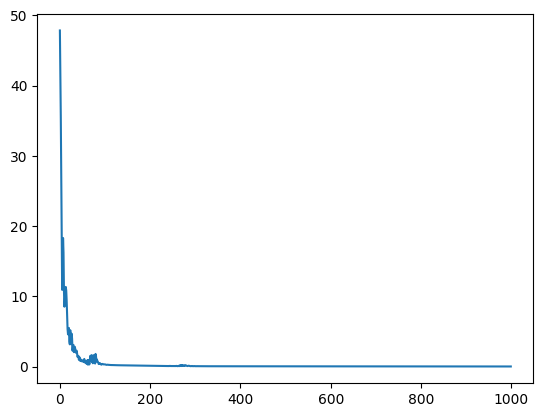

In [8]:
plt.plot(loss_list)
plt.show()

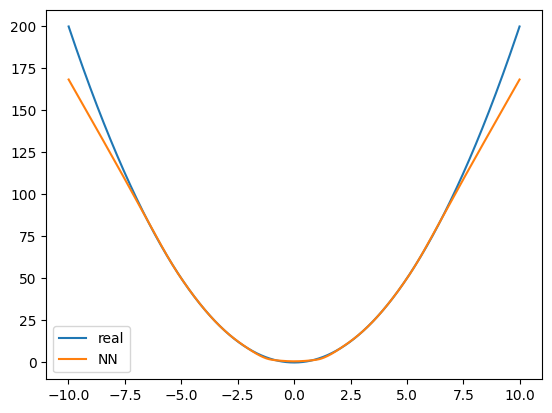

In [9]:
La=-10
Lb =10
L=Lb-La  # domain length
N = 2000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid.cpu().detach().numpy(),k)
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [10]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 4.1088572982205624
max_error: 31.50626526055194
